In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
import datalab_utils
import time

from astropy.coordinates import SkyCoord
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert
from tqdm import tqdm

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
fig_dir = "/dlusers/adriansh/work/analyses/plots/strings/develop/"

In [2]:
def count_detections(df, dmag, n, bw, achromatic):
    vals = df["filter"]

    if achromatic:
        indices = [vals[i:i+n].index for i in range(len(vals)- (n - 1)) if len(set(vals[i:i+n])) >= 2]
    else:
        indices = [vals[i:i+n].index for i in range(len(vals)- (n - 1))]

    n_lensed = len(indices)
    detected = [lens_and_detect(df, dmag, idxs, bw) for idxs in indices]
    n_detected = sum(detected)
    oid = df.iloc[0, 0]
    result = pd.DataFrame(data={"lensed": [n_lensed], "detected": [n_detected]}, index=[oid])
    return result

def lens_and_detect(df, dmag, idxs, bw):
    old_vals = df.loc[idxs, "mag_auto"]
    df.loc[idxs, "mag_auto"] = old_vals + dmag
    cl = datalab_utils.cluster_label_dataframe(df, bandwidth=bw)
    df.loc[idxs, "mag_auto"] = old_vals
    result = datalab_utils.lens_filter(cl)
    return result

def calculate_efficiency(df, delta_mag, n, bandwidth, achromatic=True):
    injection_results = df.groupby(by="objectid", group_keys=False).apply(count_detections, delta_mag, n, bandwidth, achromatic)
    totals = injection_results.sum(axis=0)
    result = totals["detected"] / totals["lensed"]
    return result

In [3]:
lmc_center = SkyCoord("05h23m34s", "−69d45.4m")
lmc_ra = lmc_center.ra.deg
lmc_dec = lmc_center.dec.deg
search_radius = 15
n_detections = 10
sigma_cutoff = 0.1

In [10]:
oq = f"""
SELECT id 
    FROM nsc_dr2.object
        WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {search_radius})
        AND class_star > 0.9
        AND
        (CASE 
            WHEN ndetu > {n_detections} 
            AND urms < {sigma_cutoff} THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetg > {n_detections} 
            AND grms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetr > {n_detections} 
            AND rrms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndeti > {n_detections} 
            AND irms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetz > {n_detections} 
            AND zrms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetY > {n_detections} 
            AND Yrms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END >= 3)
"""

qc.query(sql=oq, out="mydb://temp", timeout=1200)

'OK'

In [11]:
qq = f"""
SELECT ROW_NUMBER() OVER() - 1 AS row_number, id
    FROM mydb://temp
"""

qc.query(sql=qq, out="mydb://stable_lmc_ids2", timeout=1200)

'OK'

In [4]:
sub_query = f"""
SELECT id 
    FROM mydb://ordered_lmc_ids 
    WHERE row_number BETWEEN 0 AND 99
"""

query = f"""
SELECT m.objectid, m.filter, m.mag_auto, m.magerr_auto, m.mjd, m.exposure, e.exptime
    FROM nsc_dr2.meas AS m
    INNER JOIN nsc_dr2.exposure AS e
    ON e.exposure = m.exposure
    WHERE m.objectid IN ({sub_query})
"""

lc = qc.query(sql=query, timeout=1200, fmt="pandas")
lc = lc.groupby(by=["objectid", "filter"]).filter(lambda x: len(x) >= 3)
lc.sort_values(by="mjd", inplace=True)

In [56]:
import importlib
importlib.reload(datalab_utils)

# cl = datalab_utils.cluster_label_dataframe(lc, bandwidth=0.13)
calculate_efficiency(lc, -2.5 * np.log10(2), 30, .13)

0.5421787127681733

In [ ]:
# objective = (-n_bg / n_bg.max()) + (n_uni / n_uni.max()) + (eff / eff.max())
x = np.arange(5, 35, 10)
eff_n = [calculate_efficiency(lc, -2.5 * np.log10(2), n, .11) for n in tqdm(x)]
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x, eff_n)
ax.set_xlabel("N Samples Lensed", fontsize=16)
ax.set_ylabel("Efficiency", fontsize=16)
# ax.set_title("Fraction of Stars With Stable Baseline", fontsize=22)
ax.tick_params(labelsize=14)
ax.grid(visible=True)
fig.savefig(f"{fig_dir}efficiency_v_n_lensed.png")
plt.show(fig)

 67%|██████▋   | 2/3 [03:10<01:33, 93.67s/it] 

In [19]:
bandwidths = np.arange(0.09, 0.19, 0.01)
n_bg = np.zeros(bandwidths.shape)
n_uni = np.zeros(bandwidths.shape)
eff = np.zeros(bandwidths.shape)
dmag = -2.5 * np.log10(2)
n = 2

for i in tqdm(range(len(bandwidths))):
    bw = bandwidths[i]
    cl = datalab_utils.cluster_label_dataframe(lc, bandwidth=bw)
    g = cl.groupby(by="objectid")
    lens_fil = g.filter(datalab_utils.lens_filter)
    uni_fil = g.filter(datalab_utils.unimodal_filter)
    n_bg[i] = len(lens_fil["objectid"].unique())
    n_uni[i] = len(uni_fil["objectid"].unique())
    eff[i] = calculate_efficiency(uni_fil.drop(columns="cluster_label", axis=0), dmag, n, bw)

100%|██████████| 10/10 [2:30:06<00:00, 900.70s/it] 


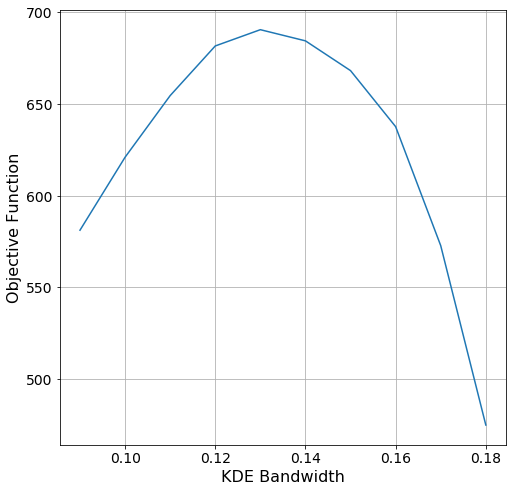

In [37]:
# objective = (-n_bg / n_bg.max()) + (n_uni / n_uni.max()) + (eff / eff.max())
objective = n_uni * eff
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(bandwidths, objective)
ax.set_xlabel("KDE Bandwidth", fontsize=16)
ax.set_ylabel("Objective Function", fontsize=16)
# ax.set_title("Fraction of Stars With Stable Baseline", fontsize=22)
ax.tick_params(labelsize=14)
ax.grid(visible=True)
fig.savefig(f"{fig_dir}objective_function_v_bandwith.png")
plt.show(fig)

In [22]:
# bw = 0.11
# batch_size = int(1e5)
# n_objects = 6619504
# num_batches = int(n_objects / batch_size) + 1
# poll_rate = 60
# batch_nums = np.arange(0, num_batches)
min_num_detections = 3

sub_query = f"""
SELECT id
    FROM mydb://stable_lmc_ids2
    ORDER BY RANDOM()
    LIMIT 100
"""

query = f"""
SELECT m.objectid, m.filter, m.mag_auto, m.magerr_auto, m.mjd, m.exposure, e.exptime
    FROM nsc_dr2.meas AS m
    INNER JOIN nsc_dr2.exposure AS e
    ON e.exposure = m.exposure
    WHERE m.objectid IN ({sub_query})
"""
lc = qc.query(sql=query, fmt="pandas", timeout=1200)
lc = lc.groupby(by=["objectid", "filter"]).filter(lambda x: len(x) >= min_num_detections)
lc.sort_values(by="mjd", inplace=True)

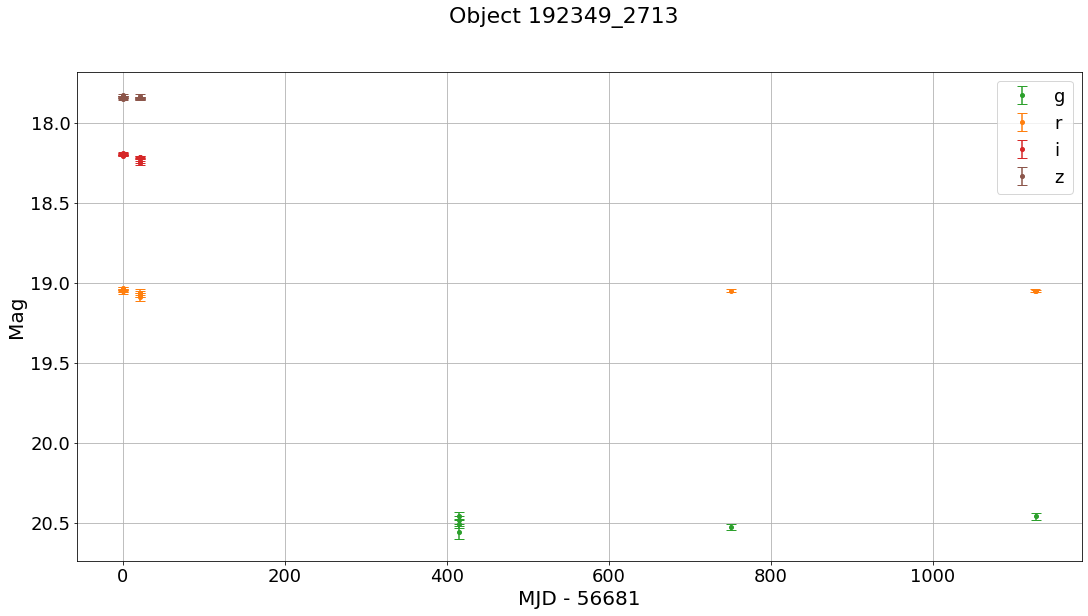

In [80]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown"])
filters = np.array(['u', 'g', 'r', 'i', 'z'])

fig, ax = plt.subplots(1, 1, figsize=(18, 9))
min_mjd = int(lc["mjd"].min())

for f, c in zip(filters, colors):
    m_f = lc["filter"] == f
    lc_full = lc.loc[m_f]

    if len(lc_full) > 0:
        ax.errorbar(lc_full["mjd"] - min_mjd, lc_full['mag_auto'], 
                    yerr=lc_full["magerr_auto"], marker='.', ms=8,
                    capsize=5, color=c, ls="None", label=f)

ax.set_ylabel('Mag', fontsize=20)
ax.tick_params(labelsize=18)
ax.invert_yaxis()
ax.grid(visible=True)
legend = ax.legend(fontsize=18, loc="upper right")
ax.set_xlabel(f'MJD - {min_mjd}', fontsize=20)
fig.suptitle(f"Object {lc.iloc[0, 0]}", fontsize=22)
# ax.set_xlim((740, 760))

plt.show(fig)
fig.savefig(f"{fig_dir}{lc.iloc[0, 0]}_lightcurve.png")
plt.close(fig)

In [18]:
delta_mags = -np.linspace(0.1, 2.5, num=25)
bandwidths = 2.5 * np.log10(2) * np.linspace(1/20, 1/4, num=21)

In [6]:
achromatic_rates2 = np.array([calculate_detection_rate(lc, dmag, 2, 0.11, achromatic=True) for dmag in tqdm(delta_mags)])
# chromatic_rates2 = np.array([calculate_detection_rate(lc, dmag, 2, bw, achromatic=False) for dmag in tqdm(delta_mags)])

 12%|█▏        | 3/25 [15:59<1:57:11, 319.63s/it]

KeyboardInterrupt: 

In [ ]:
detection_rates_n3 = np.array([calculate_detection_rate(lc, dmag, 3, bw) for dmag in delta_mags])

In [26]:
# sums = detection_rates.sum(axis=1)
# detection_rates = sums[:, 1] / sums[:, 0]
stair_edges = np.concatenate(([0], delta_mags))

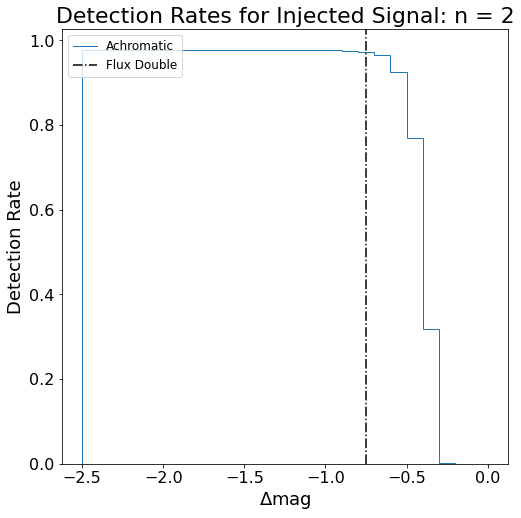

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.stairs(achromatic_rates2, edges=stair_edges, label="Achromatic")
# ax.stairs(chromatic_rates2, edges=stair_edges, label="Chromatic")
ax.set_title("Detection Rates for Injected Signal: n = 2", fontsize=22)
ax.set_ylabel("Detection Rate", fontsize=18)
ax.set_xlabel(r"$\Delta$mag", fontsize=18)
# ax.axvspan(-2.5 * np.log10(2.3), -2.5 * np.log10(1.7), alpha=0.2, 
#            color="tab:gray", label="Default Passband")
ax.axvline(-2.5 * np.log10(2), color='k', ls="-.", label="Flux Double")
ax.legend(loc="upper left", fontsize=12)
ax.tick_params(labelsize=16)
fig.savefig(f"{fig_dir}detection_rate_bw0-1_n2.png")
plt.show(fig)

In [7]:
pass_percentage = []

for b in tqdm(bandwidths):
    cl = datalab_utils.cluster_label_dataframe(lc, bandwidth=b)
    stable = cl.groupby(by=["objectid", "filter"]).apply(lambda x: (x["cluster_label"] == 1).all())
    pass_percentage.append(stable.sum() / len(stable))


100%|██████████| 21/21 [02:22<00:00,  6.78s/it]


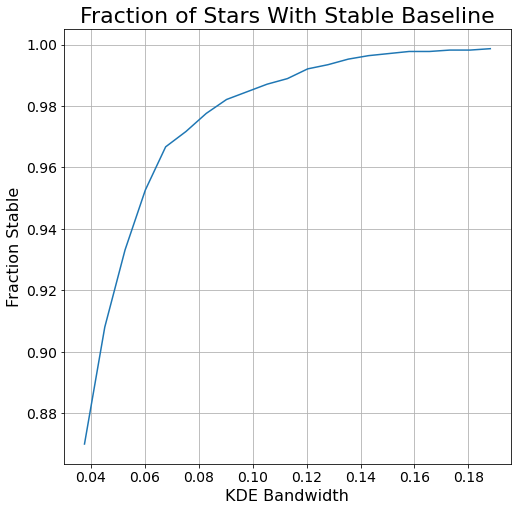

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(bandwidths, pass_percentage)
ax.set_xlabel("KDE Bandwidth", fontsize=16)
ax.set_ylabel("Fraction Stable", fontsize=16)
ax.set_title("Fraction of Stars With Stable Baseline", fontsize=22)
ax.tick_params(labelsize=14)
ax.grid(visible=True)
# fig.savefig(f"{fig_dir}fraction_stable_v_bandwith.png")
plt.show(fig)

In [23]:
rates_bw = np.array([calculate_detection_rate(lc, -2.5 * np.log10(2), 2, b, achromatic=True) for b in tqdm(bandwidths)])



  0%|          | 0/21 [00:00<?, ?it/s]

  5%|▍         | 1/21 [01:42<34:18, 102.90s/it]

 10%|▉         | 2/21 [03:25<32:27, 102.50s/it]

 14%|█▍        | 3/21 [05:07<30:39, 102.22s/it]

 19%|█▉        | 4/21 [06:48<28:54, 102.04s/it]

 24%|██▍       | 5/21 [08:30<27:12, 102.00s/it]

 29%|██▊       | 6/21 [10:12<25:29, 101.98s/it]

 33%|███▎      | 7/21 [11:54<23:46, 101.92s/it]

 38%|███▊      | 8/21 [13:36<22:06, 102.03s/it]

 43%|████▎     | 9/21 [15:18<20:22, 101.91s/it]

 48%|████▊     | 10/21 [17:01<18:43, 102.18s/it]

 52%|█████▏    | 11/21 [18:42<17:00, 102.03s/it]

 57%|█████▋    | 12/21 [20:24<15:16, 101.88s/it]

 62%|██████▏   | 13/21 [22:05<13:34, 101.80s/it]

 67%|██████▋   | 14/21 [23:47<11:52, 101.83s/it]

 71%|███████▏  | 15/21 [25:30<10:12, 102.07s/it]

 76%|███████▌  | 16/21 [27:18<08:38, 103.77s/it]

 81%|████████  | 17/21 [28:58<06:50, 102.66s/it]

 86%|████████▌ | 18/21 [30:38<05:05, 101.80s/it]

 90%|█████████ | 19/21 [32:17<03:22, 101.08s/it]

 95%|█████████▌| 

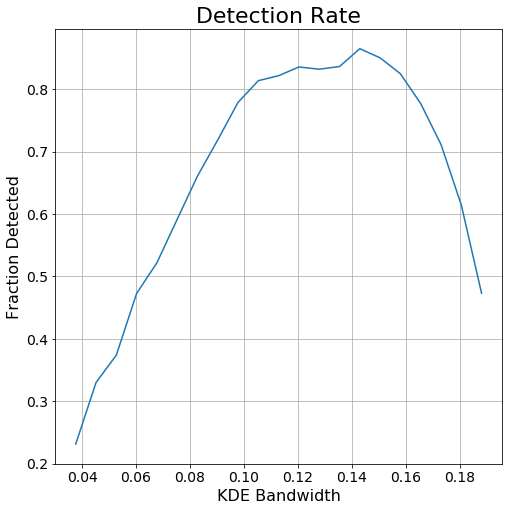

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(bandwidths, rates_bw)
ax.set_xlabel("KDE Bandwidth", fontsize=16)
ax.set_ylabel("Fraction Detected", fontsize=16)
ax.set_title("Detection Rate", fontsize=22)
ax.tick_params(labelsize=14)
ax.grid(visible=True)
# fig.savefig(f"{fig_dir}detection_rate_v_bandwidth_flux_double.png")
plt.show(fig)

In [32]:
import importlib
importlib.reload(datalab_utils)
calculate_detection_rate(lc, -2.5 * np.log10(2), 2, 0.11, achromatic=True)

0.8640305237599722

In [37]:
wstds = lc.groupby(by=["objectid", "filter"]).apply(lambda x: datalab_utils.weighted_std(x["mag_auto"].values, x["magerr_auto"].values**-2))

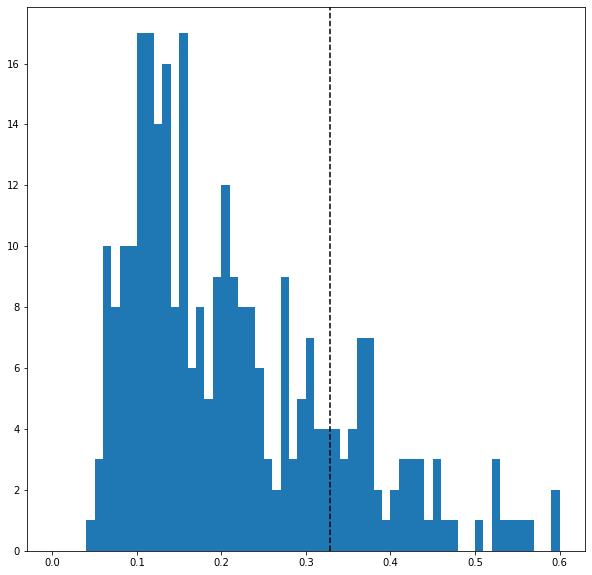

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
std_bins = np.linspace(0, .6, num=61)
ax.hist(10 * wstds, bins=std_bins)
ax.axvline(2.5 * np.log10(2.3 / 1.7), color='k', ls="--")
plt.show(fig)

In [42]:
bandwidths[10]

0.11288624837399297

In [41]:
injection_results = lc.groupby(by="objectid", group_keys=False).apply(count_detections, -2.5, 2, bw, achromatic=False)

KeyboardInterrupt: 

In [ ]:
injection_results["rate"] = injection_results["detected"] / injection_results["lensed"]

In [ ]:
oids = lc["objectid"].unique()[:10]

In [ ]:
t = datalab_utils.subtract_baseline(datalab_utils.cluster_label_dataframe(lc, bandwidth=bw))

In [83]:
lc = t

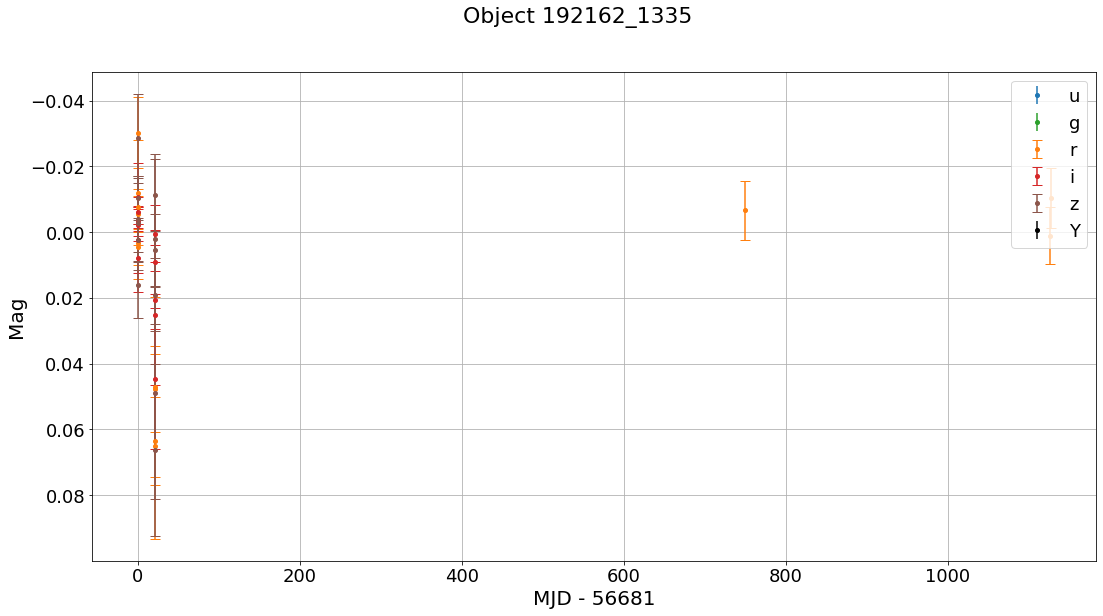

In [105]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown", 'k'])
filters = np.array(['u', 'g', 'r', 'i', 'z', 'Y'])

for oid in oids[:1]:
    m_id = lc["objectid"] == oid
    fig, ax = plt.subplots(1, 1, figsize=(18, 9))
    min_mjd = int(lc.loc[m_id, "mjd"].min())

    for f, c in zip(filters, colors):
        m_f = lc["filter"] == f
        lc_f = lc.loc[m_id & m_f]

        ax.errorbar(lc_f["mjd"] - min_mjd, lc_f['delta_mag'], 
                    yerr=lc_f["magerr_auto"], marker='.', ms=8,
                    capsize=5, color=c, ls="None", label=f)

    ax.set_ylabel('Mag', fontsize=20)
    ax.tick_params(labelsize=18)
    ax.invert_yaxis()
    ax.grid(visible=True)
    # ax.axhline(-2.5 * np.log10(2), color='k', linestyle="-.")

    legend = ax.legend(fontsize=18, loc="upper right")
    ax.set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    fig.suptitle(f"Object {oid}", fontsize=22)
    plt.show(fig)
    fig.savefig(f"{fig_dir}{oid}_lightcurve_baseline_subtracted.png")
    plt.close(fig)

In [95]:
import importlib
importlib.reload(datalab_utils)
df = lc.loc[lc["objectid"] == oids[0]].copy()
idxs = df.index
lens_and_detect(df, -.5, idxs[0:2], bw/2)

2
True True True
1
1


True

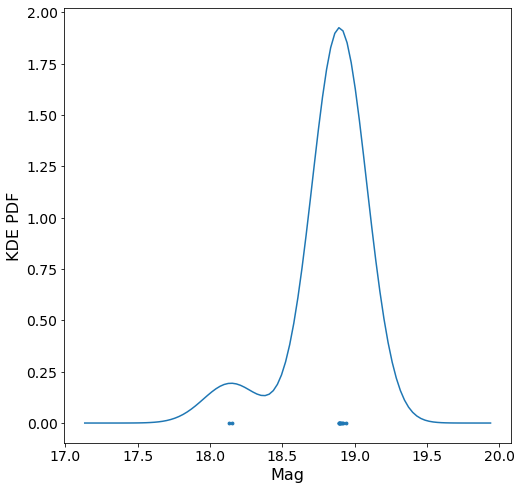

In [113]:
from scipy.stats import gaussian_kde

samples = df.loc[df["filter"] == 'i', "mag_auto"].values
weights = df.loc[df["filter"] == 'i', "magerr_auto"].values**-2
samples[:2] -= 0.75
kde = gaussian_kde(samples, bw_method=1, weights=weights)
kde.set_bandwidth(bw / np.sqrt(kde.covariance[0, 0]))
x = np.linspace(samples.min() - 1, samples.max() + 1, num=100)
pdf = kde(x)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x, pdf)
ax.scatter(samples, np.zeros(samples.shape), s=8)
ax.set_xlabel("Mag", fontsize=16)
ax.set_ylabel("KDE PDF", fontsize=16)
ax.tick_params(labelsize=14)
plt.show(fig)
fig.savefig(f"{fig_dir}kde_example_075.png")
plt.close(fig)

In [9]:
detection_rates_3 = np.array([calculate_detection_rate(lc, pass_percentage bw) for dmag in delta_mags])

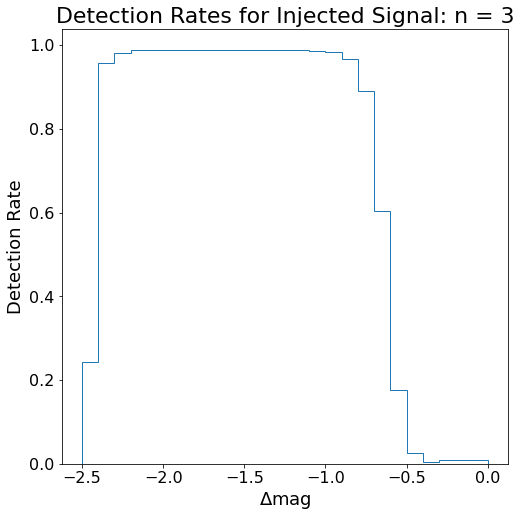

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.stairs(detection_rates_3, edges=stair_edges)
ax.set_title(f"Detection Rates for Injected Signal: n = 3", fontsize=22)
ax.set_ylabel("Detection Rate", fontsize=18)
ax.set_xlabel(r"$\Delta$mag", fontsize=18)
ax.tick_params(labelsize=16)
fig.savefig(f"{fig_dir}detection_rate_n3.png")
plt.show(fig)